In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
n_samples = 1500

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [2]:
X, y = noisy_moons

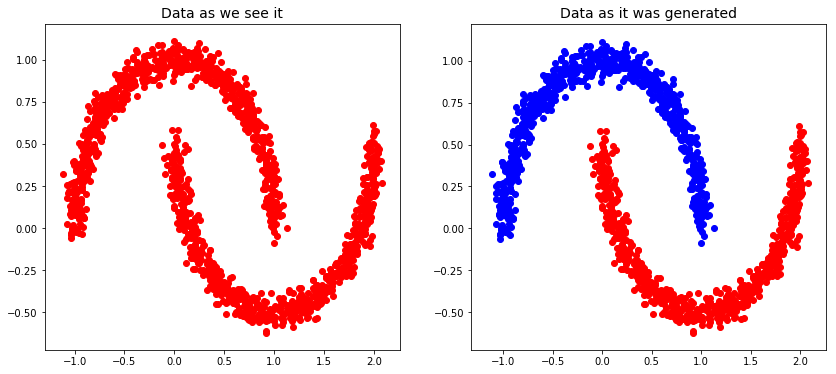

In [3]:
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==0).ravel(),0],X[(y==0).ravel(),1],color='b')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[-0.9347022   0.0926468 ]
 [ 0.85492062 -0.27444918]]


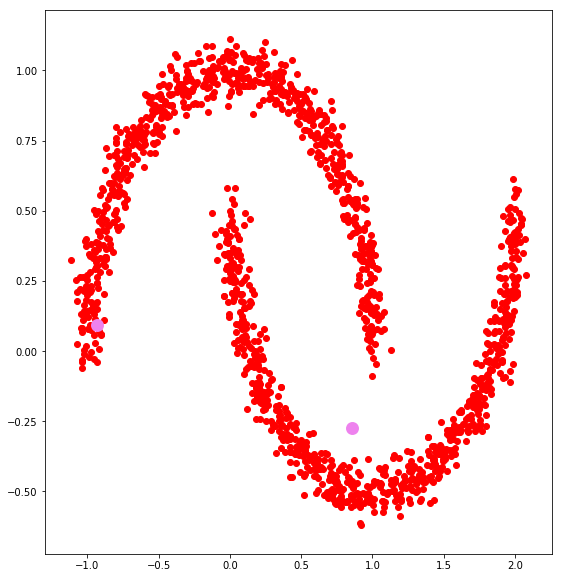

In [4]:
K =2
idx=np.random.randint(0,X.shape[0],K)
C=2*np.random.rand(K,X.shape[1])-1
Sigma=100.*np.ones((K,X.shape[1]))
Pi=(1./K)*np.ones((K,1))
print (C)

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((20,10))

In [5]:
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi
    
def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    

[[0.17949623 0.04545662]
 [0.1805442  0.0460427 ]] [[0.49827298]
 [0.50172702]]


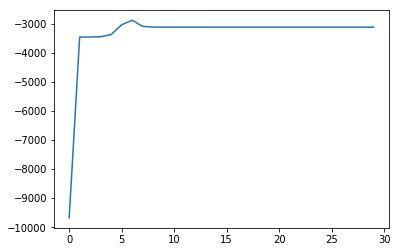

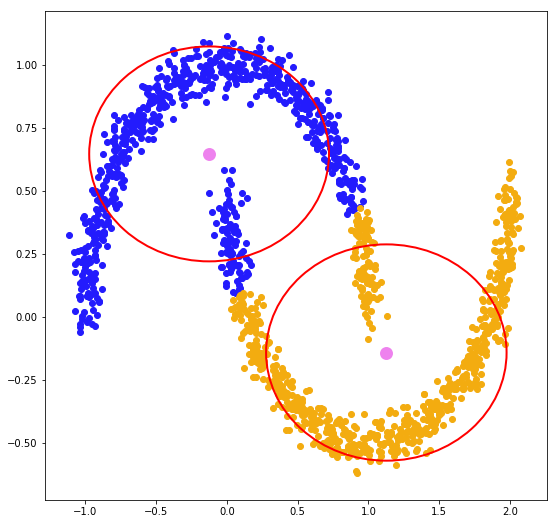

In [6]:
conv=[]
for iter in range(30):
    conv.append(evaluate_objective(X,C,Sigma,Pi))
    C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
print (Sigma,Pi)

plt.figure()
plt.plot(conv)
plt.figure()
r = define_responsibilities(X,C,Sigma,Pi)
y_pred = np.argmax(r,axis=1)
for label in np.unique(y_pred):
    plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

    
plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=2,
           zorder=10)

from matplotlib.patches import Ellipse
ax = plt.gca()
ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)


fig = plt.gcf()
fig.set_size_inches((9,9))

The previous Python code has been computed by "eliaficapalvila" and the next lines are trying to solve the problem originated by the noisy moons when we apply the Mixture of Gaussians.

Another methodology to solve this kind of problem could be using a positive semidefinite kernel function such as the Gaussian:
$$
\begin{align*}
{\bf gaussian:}&K(x_i,x_j)=exp\big( -\frac{\|x_i-x_j\|^2}{\sigma^2} \big)
\end{align*}$$

In order to evaluate the fitting goodness we use the Kernel regularized least squares, which is the following function:

$$f^*=\underset{f\in \mathcal{H}}{\operatorname{arg\,min}}\frac{1}{n}\frac{1}{2}\sum_i(f(x_i)-y_i)^2 +\frac{1}{2}\lambda\|f\|_{\mathcal{H}}^2 $$

The solution of the problem is given by the Representer's theorem:
$f^*(x)=\sum_j{\alpha_j K(x_j,x)}$

Replacing the first term we have,

$$
	\alpha^*=\underset{\alpha_i \in \mathbb{R}}{\operatorname{arg\,min}}\frac{1}{2}\sum_i{(\sum_j{\alpha_j K(x_j,x_i)}-y_i)^2}+\frac{\lambda}{2}\|f\|_{\mathcal{H}}^2
	$$




Now we find the extrema by setting the gradient with respect to $\alpha$ to $0$
\begin{align*}
-K(K\alpha -y)+\lambda K\alpha = 0\\
(K+\lambda I)\alpha = y\\
\alpha = (K+\lambda I)^{-1}y
\end{align*}

We keep this alpha which allow us to transform the points of the space in order to apply a modified Gaussian distribution which, as it can be seen at the final graphic, catches the differences between both classes.

The only thing we have to do is to look for a good value of $\gamma$ and $\lambda$. In this cases $\gamma$=1 and $\lambda$=1 have been chosen. As the Kernel regularized least squares function implies, the $\lambda$ is the penalitzation term applied to the overfiting of our model.

In [7]:
import numpy as np
from scipy.spatial import distance

def gaussian_kernel(xa,xb,gamma):
    d = distance.cdist(xa,xb,metric='euclidean')
    return np.exp(-d*gamma)

In [8]:
gamma = 1.
K = gaussian_kernel(X,X,gamma)
lamb = 1.
alpha = np.dot(np.linalg.inv(K+lamb*np.eye(K.shape[0])),y)
print(K.shape, X.shape)

(1500, 1500) (1500, 2)


(40000, 1500)


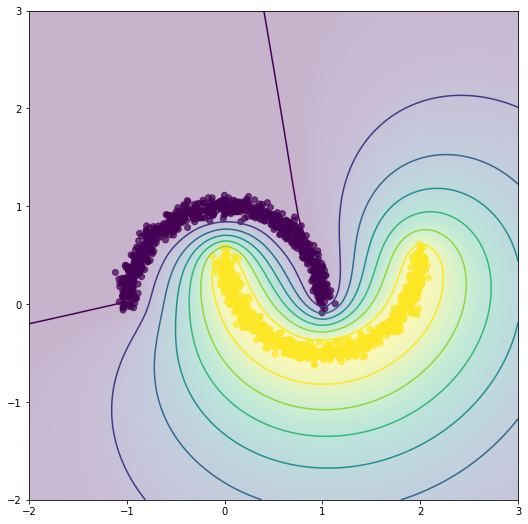

In [9]:
xx,yy = np.meshgrid(np.linspace(-2,3,200),np.linspace(-2,3,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(gaussian_kernel(viz,X,1.),alpha)
print(gaussian_kernel(viz,X,1.).shape)

plt.scatter(X[:, 0], X[:, 1], c=y,  alpha=0.7)
plt.gca().set_xlim([-2.,3.])
plt.gca().set_ylim([-2.,3.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-2,3,-2,3),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)))

plt.gcf().set_size_inches((9,9))